In [36]:
import pandas as pd
from matplotlib import pyplot as plt

from functools import partial

In [2]:
folder = "physionet.org/files/"

# Unzip csv.gz files and read them into pandas dataframes
code_names = pd.read_csv(
    folder + "mimiciv/2.2/hosp/d_icd_diagnoses.csv.gz",
    compression="gzip",
)

In [3]:
code_names.head()

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


In [5]:
diagnoses_icd = pd.read_csv(
    folder + "mimiciv/2.2/hosp/diagnoses_icd.csv.gz",
    compression="gzip",
)

In [6]:
diagnoses_icd.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [8]:
# Split into ICD version 9 and version 10
icd9 = diagnoses_icd[diagnoses_icd.icd_version == 9]
icd10 = diagnoses_icd[diagnoses_icd.icd_version == 10]

# Print counts entries
print("ICD9 count:", len(icd9))
print("ICD10 count:", len(icd10))

# Print counts of unique ICD9 and ICD10 codes
print("Unique ICD9 codes:", len(icd9.icd_code.unique()))
print("Unique ICD10 codes:", len(icd10.icd_code.unique()))

ICD9 count: 2766877
ICD10 count: 1989449
Unique ICD9 codes: 9072
Unique ICD10 codes: 16757


In [35]:
# Get all codes of hadm_id 22595853

codes_10000032 = icd9[icd9.hadm_id == 22595853]
codes_10000032

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9
5,10000032,22595853,6,29680,9
6,10000032,22595853,7,30981,9
7,10000032,22595853,8,V1582,9


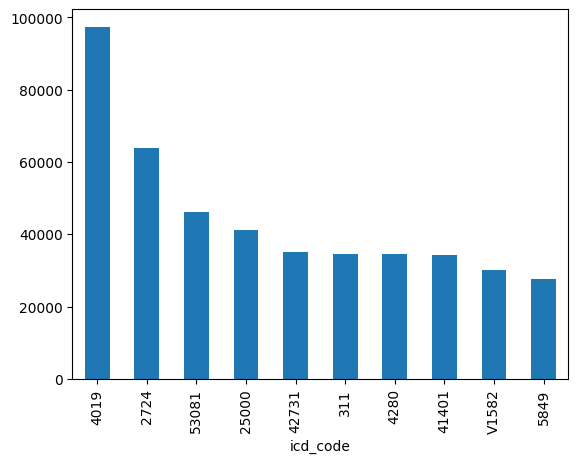

In [14]:
# Get top 10 most common ICD codes and make a bar plot
top_10_icd9 = icd9.icd_code.value_counts().head(10)
top_10_icd9.plot(kind="bar")
plt.show()

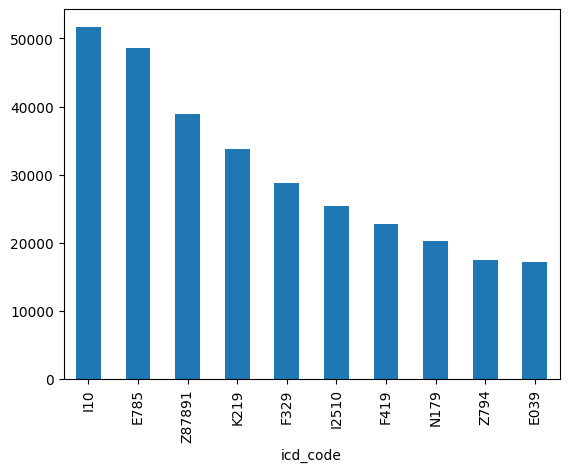

In [15]:
# Get top 10 most common ICD codes and make a bar plot
top_10_icd10 = icd10.icd_code.value_counts().head(10)
top_10_icd10.plot(kind="bar")
plt.show()

In [32]:
# Get percent of codes that have less than 5 occurrences
icd9_counts = icd9.icd_code.value_counts()
icd10_counts = icd10.icd_code.value_counts()

icd9_rare = icd9_counts < 5
icd10_rare = icd10_counts < 5

# Remove false values and print the count
print("ICD9 codes with less than 5 occurrences:", sum(icd9_rare))
print("ICD10 codes with less than 5 occurrences:", sum(icd10_rare))

# Get the percent of the database that are rare codes
print(
    "Percent of ICD9 codes that are rare:", sum(icd9_rare) / len(icd9.icd_code.unique())
)
print(
    "Percent of ICD10 codes that are rare:",
    sum(icd10_rare) / len(icd10.icd_code.unique()),
)

# Get percent of entries that have less than 5 occurrences
print(
    "Percent of ICD9 entries that are rare:",
    sum(icd9_counts[icd9.icd_code] < 5) / len(icd9),
)
print(
    "Percent of ICD10 entries that are rare:",
    sum(icd10_counts[icd10.icd_code] < 5) / len(icd10),
)

ICD9 codes with less than 5 occurrences: 2977
ICD10 codes with less than 5 occurrences: 8488
Percent of ICD9 codes that are rare: 0.328152557319224
Percent of ICD10 codes that are rare: 0.5065345825625112
Percent of ICD9 entries that are rare: 0.0021526074343022838
Percent of ICD10 entries that are rare: 0.007769487933593673


In [37]:
def basic_parse_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # Drop rows with missing values
    df = df.dropna()
    # Drop duplicate rows
    df = df.drop_duplicates(subset=["hadm_id", "icd_code"])
    return df